In [1]:
!lscpu |grep 'Nome do modelo'

In [2]:
import pandas as pd
import numpy as np
import operator

import torch
import numpy as np
import time
import os
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import scikitplot as skplt
import matplotlib.pyplot as plt


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Nov 22 11:21:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060        Off | 00000000:01:00.0  On |                  N/A |
| 33%   39C    P5              N/A / 115W |    953MiB /  8188MiB |     54%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import gc
from sys import getsizeof

def split_into_nibbles(array):
    array = np.array(array)
    shape = list(array.shape)
    shape[-1] *= 2
    array2 = (array.reshape(-1, 1) & np.array([0xF0, 0x0F], dtype=np.uint8)) >> np.array([4, 0], dtype=np.uint8)
    return array2.reshape(shape)

def create_dataset(dataset, ypsilons, look_back=44, size_bytes=58):
    X, Y = [], []
    look_back += 1

    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        X.append(a)
        # Y.append(ypsilons.iloc[i+look_back][0]) #verificar se tem pacotes maliciosos
        if np.all(np.array(ypsilons[i:(i+look_back)])== 0):
          Y.append(0)
        else:
          Y.append(1)

    features=[]
    print(len(X))
    for i in range(len(X)):
      deltaX=[]
      e=0
      for e in range(look_back-1):  
        e+=1
        b = split_into_nibbles([((a_i - b_i) % 256) for a_i, b_i in list(zip(X[i][e][:size_bytes], X[i][e-1][:size_bytes]))])       
        deltaX.append(b)
      features.append(np.array(deltaX, dtype=np.uint8))
      # if i == 1490000:
      #   break;
      if not i % 100000:
        gc.collect()
        print(i)
    print(len(features))
    return np.array(features), np.array(Y)

In [4]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score
from scipy.stats import ks_2samp
import scikitplot as skplt


import matplotlib.pyplot as plt
import sklearn

from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve, auc


def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.savefig("ks_plot.png")
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

# Load Data

In [5]:
path = "/home/pedro/projetoDL/dataset/processado/"
log_path_tmp = "/home/pedro/projetoDL/log"

In [6]:
Y = np.load(path + 'Y_test_Driving_NewApproach_Injected_v2.npz')
Y= Y.f.arr_0

X = np.load(path + 'X_test_Driving_NewApproach_Injected_v2.npz')
X = X.f.arr_0

In [7]:
from sklearn.model_selection import train_test_split

# Definir 2/3 dos dados
X, _, Y, _ = train_test_split(
    X, Y, train_size=1/5, stratify=Y, random_state=42  # Stratify para manter a proporção de classes
)

# Agora X_subset e Y_subset têm 2/3 dos dados originais
# X = X_subset
# del X_subset
# Y = Y_subset
# del Y_subset

gc.collect()

22

In [8]:
import torch.nn as nn

# Definindo a rede neural
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        #self.bn1 = nn.BatchNorm2d(32)
        self.bn1 = nn.Identity()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        #self.bn2 = nn.BatchNorm2d(64)
        self.bn2 = nn.Identity()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 11 * 29, 64)  # Dimensão calculada
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool1(self.bn1(torch.relu(self.conv1(x))))
        x = self.pool2(self.bn2(torch.relu(self.conv2(x))))
        x = self.flatten(x)
        x = self.dropout1(torch.relu(self.fc1(x)))
        x = self.dropout2(self.fc2(x))  # Sem sigmoid explícito
        return x

Carregando modelo do diretório: /home/pedro/projetoDL/log/torch/exp_20241122000332/1_fold/


/tmp/ipykernel_540496/2472988667.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path + f'fold_{fold_no}_model.pth'))


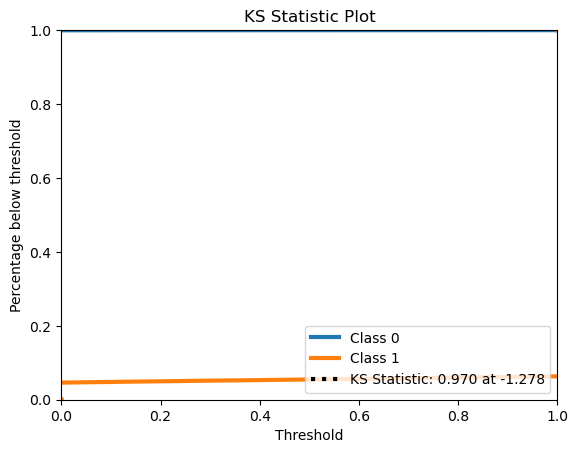

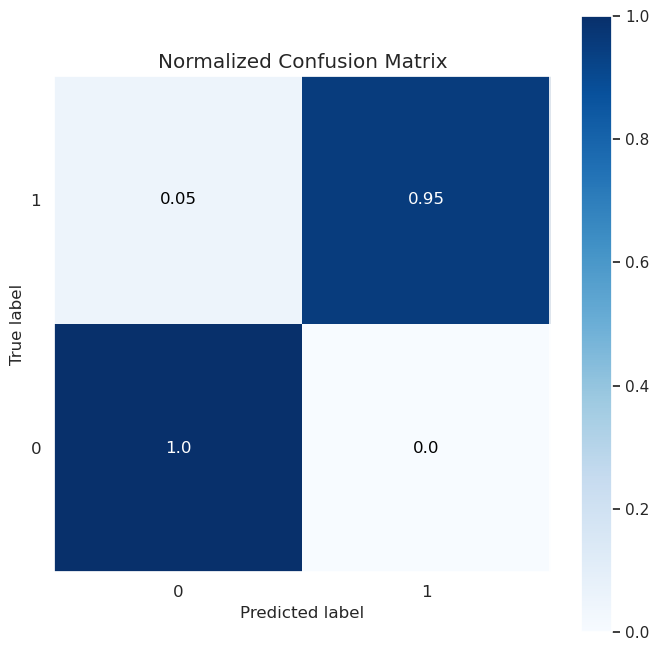

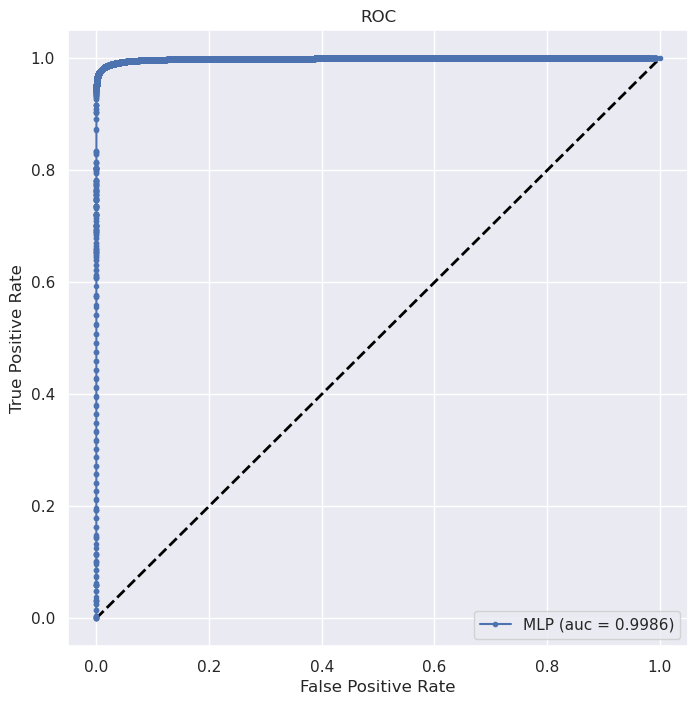

Carregando modelo do diretório: /home/pedro/projetoDL/log/torch/exp_20241122000332/2_fold/


/tmp/ipykernel_540496/2472988667.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path + f'fold_{fold_no}_model.pth'))


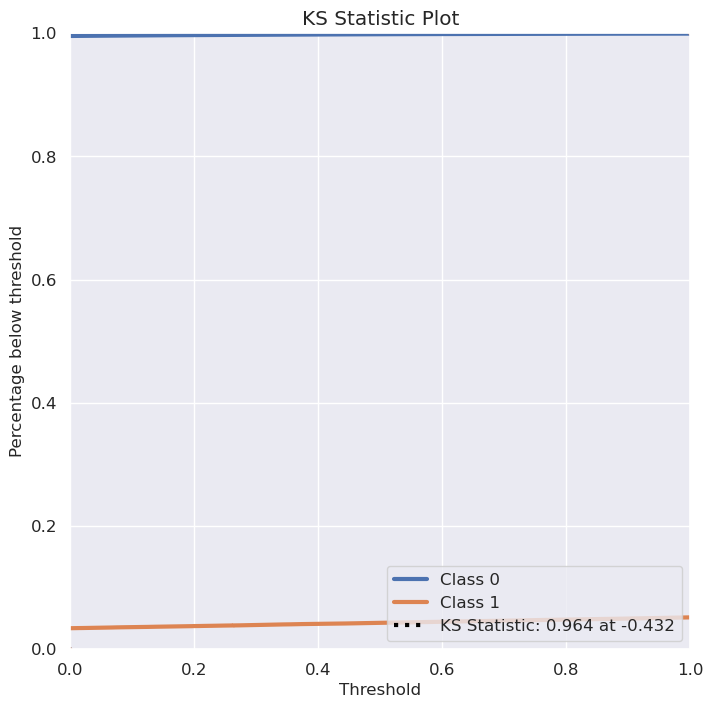

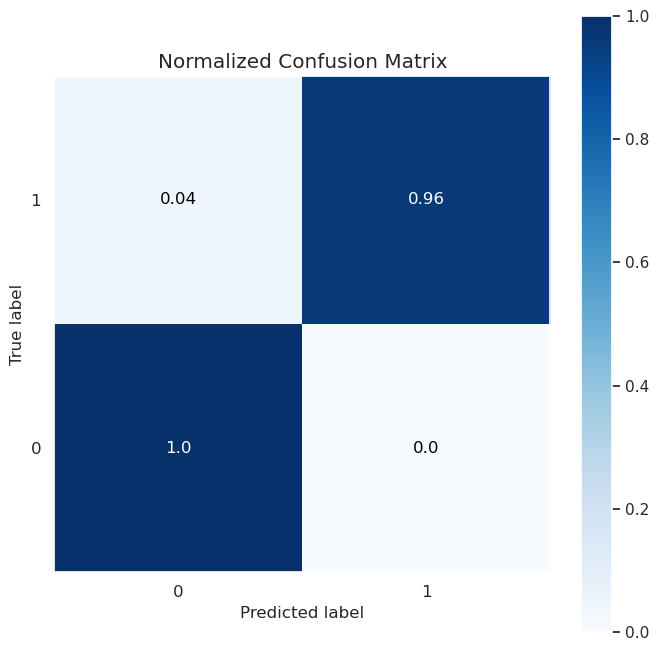

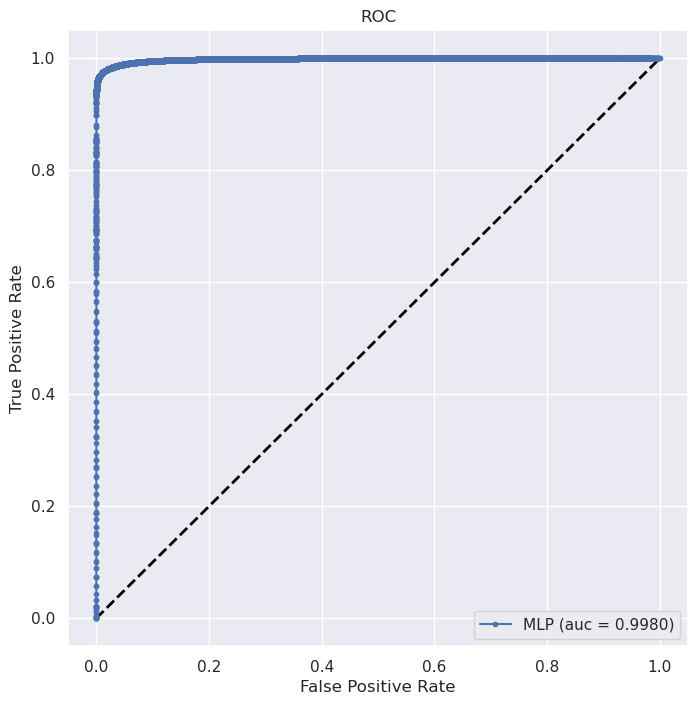

Carregando modelo do diretório: /home/pedro/projetoDL/log/torch/exp_20241122000332/3_fold/


/tmp/ipykernel_540496/2472988667.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path + f'fold_{fold_no}_model.pth'))


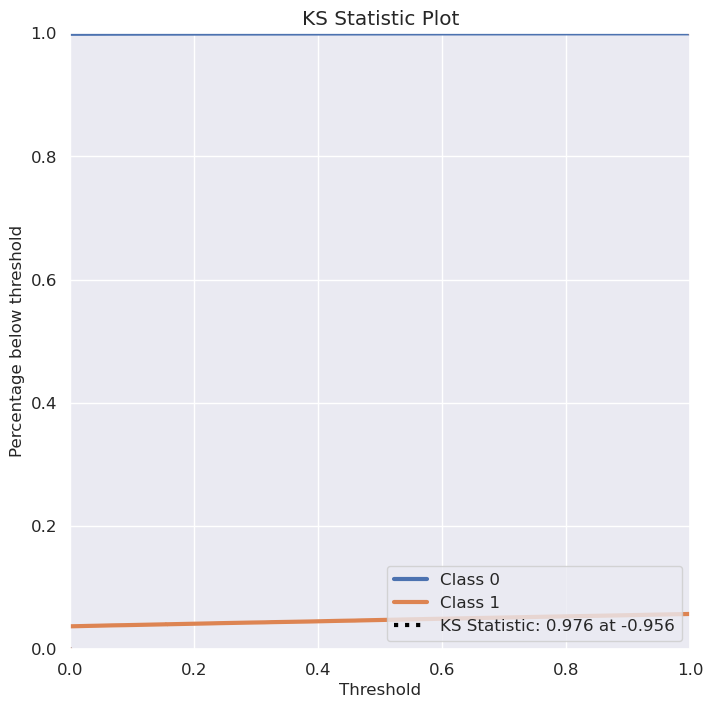

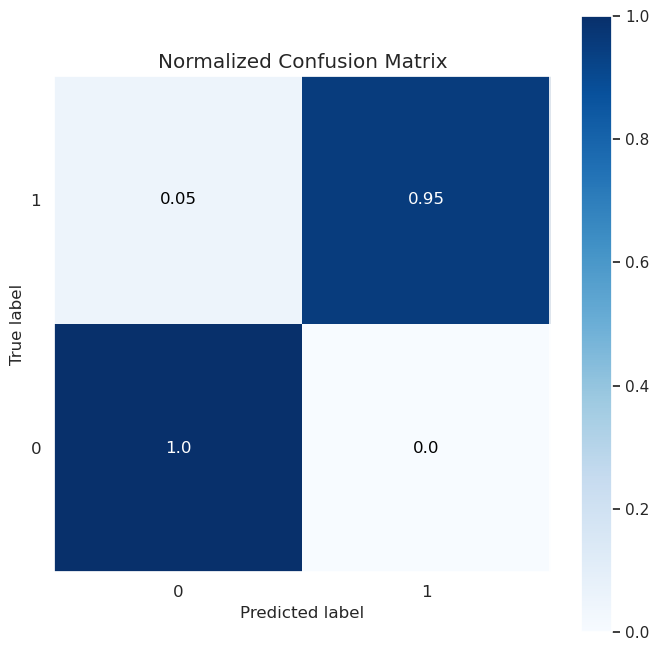

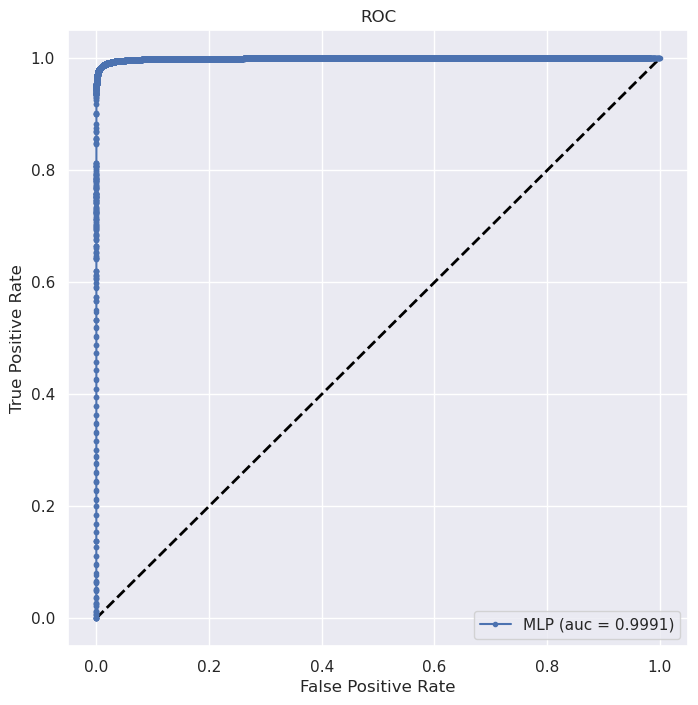

Carregando modelo do diretório: /home/pedro/projetoDL/log/torch/exp_20241122000332/4_fold/


/tmp/ipykernel_540496/2472988667.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path + f'fold_{fold_no}_model.pth'))


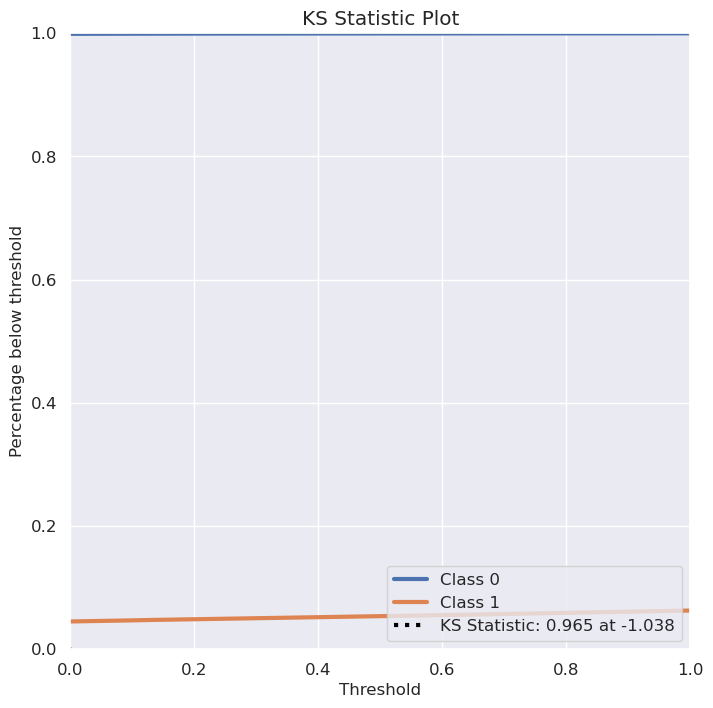

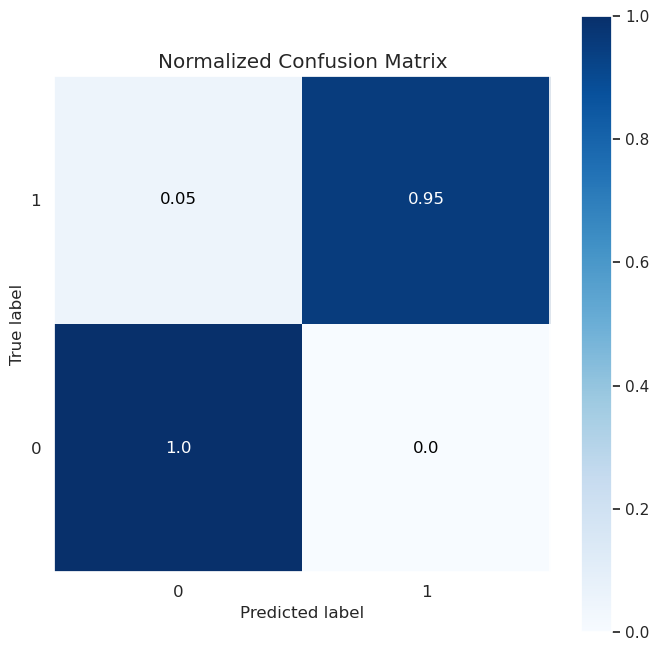

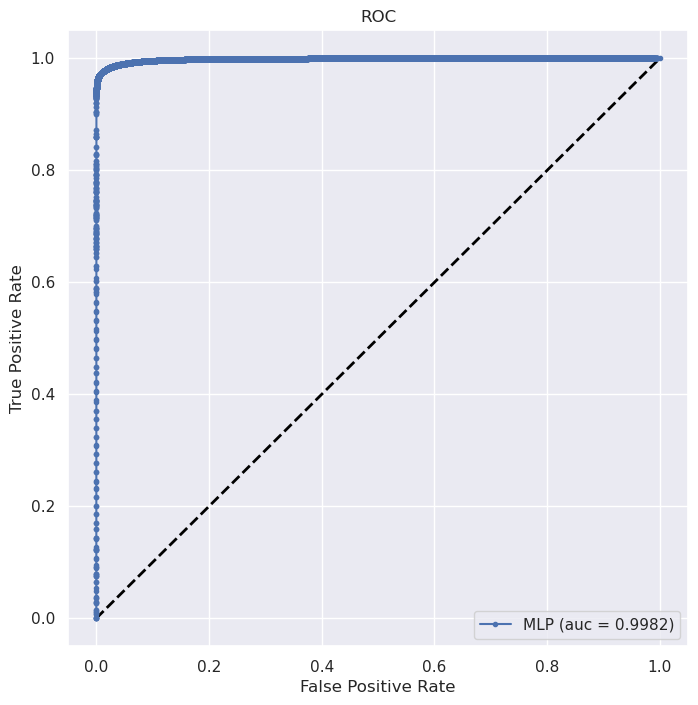

Carregando modelo do diretório: /home/pedro/projetoDL/log/torch/exp_20241122000332/5_fold/


/tmp/ipykernel_540496/2472988667.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path + f'fold_{fold_no}_model.pth'))


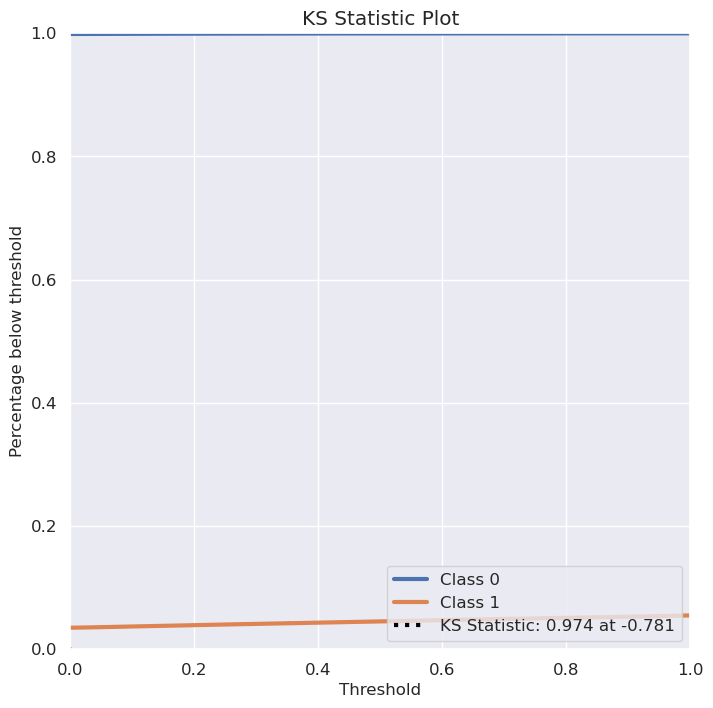

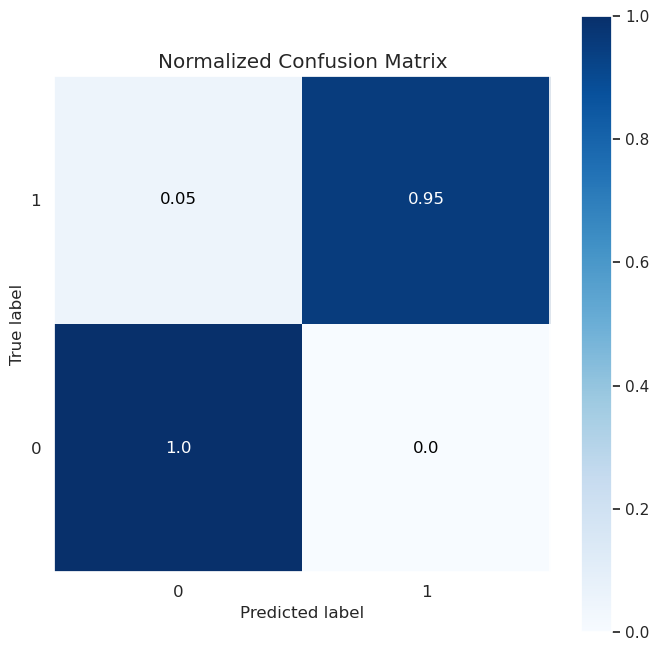

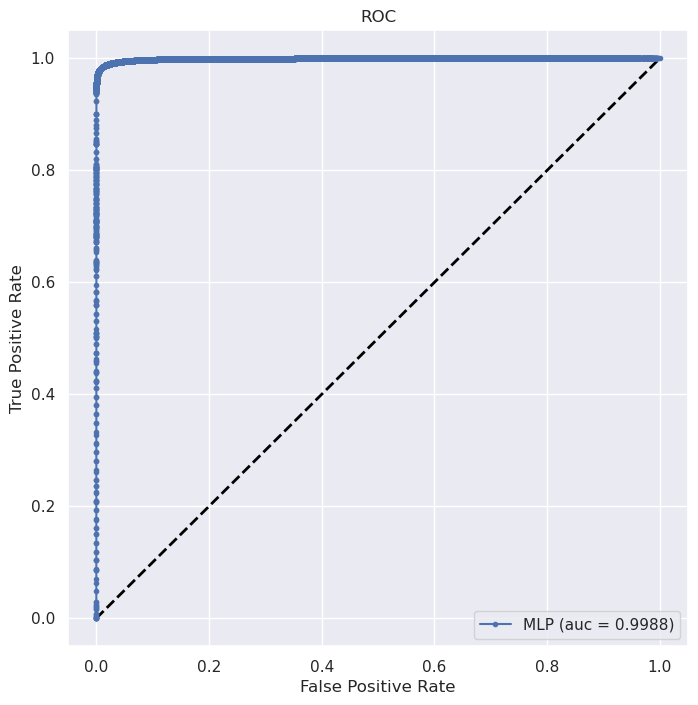

In [9]:

# Supondo que compute_performance_metrics já esteja definido
i = 1
tmp_path = '/home/pedro/projetoDL/log/torch/exp_20241122000332/{}_fold/'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Definir o dispositivo
from torch.utils.data import DataLoader, TensorDataset

# Criar DataLoader para dividir os dados em batches
batch_size = 256  # Ajuste conforme necessário para caber na GPU
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

for fold_no in [1, 2, 3, 4, 5]:
    load_path = tmp_path.format(fold_no)
    save_path = tmp_path.format(fold_no) + 'results_4060/'
    print(f"Carregando modelo do diretório: {load_path}")

    # Criar diretório de salvamento, se necessário
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    file1 = open(save_path + f'TESTE_model_{fold_no}_log.txt', "a")

    # Criar e carregar o modelo
    model = ConvNet()
    model.load_state_dict(torch.load(load_path + f'fold_{fold_no}_model.pth'))
    model.to(device)
    model.eval()

    all_y_pred_scores = []
    start = time.time()

    # Processar cada batch
    with torch.no_grad():
        for batch_X, _ in dataloader:
            batch_X = batch_X.unsqueeze(1).to(device)  # Adicionar canal
            y_pred_scores = model(batch_X).cpu().numpy()
            all_y_pred_scores.append(y_pred_scores)

    end = time.time()

    # Concatenar os resultados de todos os batches
    y_pred_scores = np.concatenate(all_y_pred_scores, axis=0)

    print(f"\nSubset size: 1/5\n", file=file1)
    print(f"Runtime of the program is {end - start}", file=file1)

    total_time = end - start
    timesample = total_time / y_pred_scores.shape[0]

    print(f"us/sample is {timesample * 1000000}", file=file1)

    # Processar os resultados
    y_pred_class = (y_pred_scores > 0.5).astype("int64")
    y_pred_scores2 = y_pred_scores
    y_pred_scores_0 = 1 - y_pred_scores
    y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(Y, y_pred_class, y_pred_scores)

    print(f'Results for fold {fold_no}: Recall of {recall}; accuracy of {accuracy}; precision of {precision}; f1 of {f1}; auroc of {auroc}; aupr of {aupr}', file=file1)

    sns.set(rc={'figure.figsize':(8,8)})
    subplot = skplt.metrics.plot_confusion_matrix(Y, y_pred_class, normalize=True)
    subplot.set_ylim(-0.5, 1.5)
    plt.savefig(save_path + "conf_matrix_TESTE.png")
    plt.show()
    
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y, y_pred_scores2)
    auc_keras = auc(fpr_keras, tpr_keras)

    sns.set(rc={'figure.figsize':(8,8)})
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    plt.plot(fpr_keras, tpr_keras, marker='.', label='MLP (auc = %0.4f)' % auc_keras)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.savefig(save_path + "plot_roc_TESTE.png")
    plt.show()     

    file1.close()
    del model
    time.sleep(3)
    gc.collect()